In [1]:
import sqlalchemy
import psycopg2
import os
import numpy
import ast
import pandas as pd
import json
import re
from lxml import etree
import numpy as np
import zipfile
from io import StringIO, BytesIO
import sumy
from sqlalchemy import create_engine
import seaborn
import nltk
nltk.download('punkt')

import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/melissaferrari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
congress = '114'
bill_type = 'hr'
default_bill_number = 4764# 1216 #
number = default_bill_number

### Get XML doc from filepath

In [3]:
bill_path_root = '/Users/melissaferrari/Projects/repo/congress/data/'

In [4]:
bill_path = '{}{}/bills/{}/{}{}/text-versions/ih/'.format(bill_path_root, 
                                                          congress, 
                                                          bill_type, 
                                                          bill_type, 
                                                          number)
bill_path += 'BILLS-{}{}{}ih/xml'.format(congress, bill_type, number)

xml_file = os.listdir(bill_path)[0]

In [5]:
tree = etree.parse(os.path.join(bill_path, xml_file))
string_tree = etree.tostring(tree).decode()

### Query XML from database

In [6]:
# bill_id = 'hr1216-114'
bill_id = '{}{}-{}'.format(bill_type, number, congress)
bill_id

'hr4764-114'

In [7]:
user = 'melissaferrari'  # add your Postgres username here
host = 'localhost'
dbname = 'congressional_bills'
db = create_engine('postgres://%s%s/%s' % (user, host, dbname))
con = None
con = psycopg2.connect(database=dbname, user=user)

In [8]:
query_text = "SELECT bill_ix, text FROM bill_text bt INNER JOIN bills b ON bt.bill_ix = b.id WHERE b.bill_id = '%s';" % bill_id
query_text_results = pd.read_sql_query(query_text, con)

In [9]:
query_text_results

,bill_ix,text
0,5530,"<?xml-stylesheet type=""text/xsl"" href=""billres..."


In [10]:
string_xml = query_text_results.iloc[0]['text']
tree = etree.fromstring(string_tree)
#summarization_result = models.do_summarization(string_xml)

In [11]:
tags = []
for elt in tree.getiterator():
    tag = elt.tag
    if '}' in tag:
        tag = tag.split('}')[1]
    tags.append(tag)
tags = list(np.unique(tags))
tags

['action',
 'action-date',
 'action-desc',
 'bill',
 'committee-name',
 'congress',
 'cosponsor',
 'current-chamber',
 'date',
 'distribution-code',
 'dublinCore',
 'enum',
 'form',
 'format',
 'header',
 'language',
 'legis-body',
 'legis-num',
 'legis-type',
 'metadata',
 'official-title',
 'paragraph',
 'publisher',
 'quote',
 'rights',
 'section',
 'session',
 'short-title',
 'sponsor',
 'subparagraph',
 'subsection',
 'text',
 'title']

In [13]:
for elt in tree.getiterator():
    if elt.text == None:
        pass
    if elt.tag == None:
        pass
    if elt.text == 'None':
        pass
    else:
        print(elt.tag)
        print(elt.text)
        print('')

bill

	

metadata



dublinCore



{http://purl.org/dc/elements/1.1/}title
114 HR 4764 IH: Puppies Assisting Wounded Servicemembers (PAWS) Act of 2016

{http://purl.org/dc/elements/1.1/}publisher
U.S. House of Representatives

{http://purl.org/dc/elements/1.1/}date
2016-03-16

{http://purl.org/dc/elements/1.1/}format
text/xml

{http://purl.org/dc/elements/1.1/}language
EN

{http://purl.org/dc/elements/1.1/}rights
Pursuant to Title 17 Section 105 of the United States Code, this file is not subject to copyright protection and is in the public domain.

form

		

distribution-code
I

congress
114th CONGRESS

session
2d Session

legis-num
H. R. 4764

current-chamber
IN THE HOUSE OF REPRESENTATIVES

action

			

action-date
March 16, 2016

action-desc
None

sponsor
Mr. DeSantis

cosponsor
Mr. Rooney of Florida

cosponsor
Mr. Rothfus

cosponsor
Ms. Stefanik

cosponsor
Mr. Nugent

cosponsor
Mr. Weber of Texas

cosponsor
Mrs. Ellmers of North Carolina

cosponsor
Mr. Meadows

cosponsor
Mr. Byrne

In [14]:
def create_single_text_string(tree, tag='text'):
    text = ""
    for elt in tree.getiterator(tag):
        if isinstance(elt.text, str):
            text += elt.text  + ' '
    return text

In [15]:
full_text = create_single_text_string(tree)

### Simple Gensim tutorial [[LINK](https://rare-technologies.com/text-summarization-with-gensim/)]

In [16]:
import gensim #from gensim import summarization #import summarize, keywords

In [17]:
len(full_text)

4642

In [18]:
summarized = gensim.summarization.summarize(full_text)

In [19]:
summarized

'This Act may be cited as the  Congress makes the following findings: An estimated 14 percent of members of the Armed Forces returning from active duty service in support of Operation Iraqi Freedom or Operation Enduring Freedom suffer from post-traumatic stress disorder.\nIn carrying out the pilot program under this section, the Secretary shall enter into such contracts as may be necessary for the procurement and training of service dogs with appropriate providers that are certified by Assistance Dogs International or a similar organization that— on average, provides one-on-one training for each service canine for a minimum of 30 hours over at least 90 days including a wellness verification from a licensed veterinarian; provides an in-house residential facility in which service dog recipients stay for a minimum of ten days while receiving at least 30 hours of training with their new service canine; ensures all service canines pass the American Kennel Club Canine Good Citizen test prior

In [20]:
len(summarized)/len(full_text)

0.2847910383455407

In [21]:
len(full_text) - len(summarized)

3320

In [22]:
kw = gensim.summarization.keywords(full_text)

In [23]:
print(kw)

shall
provider
providers
provides
canine
canines
disorder
treatment provided
provide social
including
include
dogs
dog
affairs
service
health
forces
response
veterans
veteran
care
freedom
societal
humans
human
compliance
medical
medication
established
metric
metrics
stress
support
ptsd
furnish
furnished
satisfactory
severity
severe
significantly


# Implementing ROUGE
[GITHUB REPO](https://github.com/Diego999/py-rouge)

In [24]:
bill_id

'hr4764-114'

In [25]:
query_info = "SELECT bill_id, official_title, short_title, subjects_top_term FROM bills WHERE bill_id='%s';" % bill_id
query_info_results = pd.read_sql_query(query_info, con)
query_info_results

,bill_id,official_title,short_title,subjects_top_term
0,hr4764-114,To direct the Secretary of Veterans Affairs to...,Puppies Assisting Wounded Servicemembers (PAWS...,Armed forces and national security


In [26]:
_, official_title, short_title, subjects_top_term = query_info_results.iloc[0].values

In [27]:
query_summary = """
                SELECT bill_ix, text FROM summaries bt INNER JOIN bills b
                ON bt.bill_ix = b.id WHERE b.bill_id = '%s';
                """
data = (bill_id,)
query_summary_results = pd.read_sql_query(query_summary % data, con)

query_summary_results

,bill_ix,text
0,5530,Puppies Assisting Wounded Servicemembers (PAWS...


In [28]:
actual_summary = query_summary_results.iloc[0]['text']
# Remove summary title
to_remove = actual_summary.split('\n\n')[0]
if to_remove == short_title:
    print('REMOVED THE FOLLOWING TEXT: \n{}'.format(to_remove))
else:
    print('Did not remove first sentence: \n{}'.format(to_remove))
actual_summary = actual_summary.split(actual_summary.split('\n\n')[0] + '\n\n')[1]
actual_summary = actual_summary.replace('\n\n', ' ')

REMOVED THE FOLLOWING TEXT: 
Puppies Assisting Wounded Servicemembers (PAWS) Act of 2016


In [29]:
actual_summary

'This bill directs the Department of Veterans Affairs (VA), through the Office of Patient Centered Care and Cultural Transformation, to carry out a five-year pilot program under which the VA shall provide service dogs and veterinary health insurance to certain veterans who: (1) served on active duty on or after September 11, 2001; and (2) were diagnosed with, and continue to suffer from, post-traumatic stress disorder. The provision of a service dog shall be done in addition to other types of treatment for post-traumatic stress disorder and shall not replace established treatment modalities.'

In [30]:
## DEFINE ROUGE EVALUATOR
evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                        max_n=4,
                        limit_length=True,
                        length_limit=100,
                        length_limit_type='words',
                        alpha=0.5, # Default F1_score
                        weight_factor=1.2,
                        stemming=True)

In [31]:
scores = evaluator.get_scores(summarized, actual_summary)

In [32]:
try:
    rouge_df = pd.DataFrame(scores).transpose()
except:
    for metric, results in sorted(scores.items(), key=lambda x: x[0]):
        results = {key: value[0] for key, value in results[0].items()}
        scores[metric] = results
    rouge_df = pd.DataFrame(scores).transpose()
rouge_df

,f,p,r
rouge-4,0.031088,0.030000,0.032258
rouge-1,0.391960,0.378641,0.406250
rouge-2,0.101523,0.098039,0.105263
rouge-3,0.051282,0.049505,0.053191
rouge-l,0.326835,0.317527,0.336707
rouge-w,0.101696,0.168925,0.072745


In [33]:
rouge_df = np.multiply(rouge_df, 100.0)
rouge_df.columns = ['F1', 'P', 'R']
rouge_df

,F1,P,R
rouge-4,3.108808,3.000000,3.225806
rouge-1,39.195980,37.864078,40.625000
rouge-2,10.152284,9.803922,10.526316
rouge-3,5.128205,4.950495,5.319149
rouge-l,32.683550,31.752659,33.670670
rouge-w,10.169629,16.892462,7.274526


In [34]:
def apply_rouge_naive(auto_summarization, actual_summarization, 
                      metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                      max_n=4, weight_factor=1.2, stemming=True, 
                      percent=False):
    
    ## DEFINE ROUGE EVALUATOR
    evaluator = rouge.Rouge(metrics=metrics,
                            max_n=max_n,
                            limit_length=True,
                            length_limit=100,
                            length_limit_type='words',
                            alpha=0.5, # Default F1_score
                            weight_factor=weight_factor,
                            stemming=stemming)
    
    scores = evaluator.get_scores(auto_summarization, actual_summarization)
    try:
        rouge_df = pd.DataFrame(scores).transpose()
    except:
        for metric, results in sorted(scores.items(), key=lambda x: x[0]):
            results = {key: value[0] for key, value in results[0].items()}
            scores[metric] = results
        rouge_df = pd.DataFrame(scores).transpose()
    if percent:
        rouge_df = np.multiply(rouge_df, 100.0)
        rouge_df.columns = ['F1', 'P', 'R']
    return rouge_df

### Random Summary Generator

In [38]:
import random
import itertools
import time

In [39]:
# choose random set of sentence locs 
sentence_locs = list(np.arange(1, num_sentences_full+1))
sentence_nums = random.sample(sentence_locs, num_sentences_sum)
sentence_nums = sorted(sentence_nums)

In [40]:
def calculate_factorial(n):
    total = n
    n = n-1 
    while n >=1:
        total = total*n
        n = n -1 
    return total

In [41]:
def calculate_combinations(n, k):
    return int(np.divide(calculate_factorial(n), calculate_factorial(k)*calculate_factorial(n-k)))

In [42]:
def calculate_permutations(n, k):
    return int(np.divide(calculate_factorial(n), calculate_factorial(n-k)))

In [43]:
num_combinations = calculate_combinations(num_sentences_full, num_sentences_sum)
print('Number of {} combinations from set of {} elements is: {}'.format(num_sentences_sum, num_sentences_full, num_combinations))

Number of 4 combinations from set of 17 elements is: 2380


In [44]:
random_summaries = list(itertools.combinations(full_text.split('.'), num_sentences_sum))
random_summaries = ['. '.join(random_summary) for random_summary in random_summaries]

In [45]:
len(random_summaries)

2380

In [46]:
rouge1_random_sum = pd.DataFrame()
for ix, random_summary in enumerate(random_summaries):
    rouge1_random_sum = rouge1_random_sum.append(apply_rouge_naive(random_summary, actual_summary, 
                                                                   metrics=['rouge-n'], max_n=1).set_index(pd.Index([ix])))

In [47]:
random_summ_sentence_locs = list(itertools.combinations(np.arange(1, 18), 4))

In [48]:
rouge1_random_stats = rouge1_random_sum[['f']].describe()
rouge1_random_stats

,f
count,2380.000000
mean,0.456149
std,0.080205
min,0.294118
25%,0.391960
50%,0.453202
75%,0.515152
max,0.670391


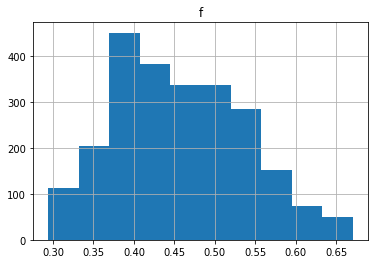

In [49]:
fig, ax = plt.subplots()
rouge1_random_sum[['f']].hist(ax=ax);

In [50]:
max_rouge = rouge1_random_stats.loc['max', 'f']
max_rouge

0.6703910614525139

In [51]:
min_rouge = rouge1_random_stats.loc['min', 'f']
min_rouge

0.2941176470588236

In [52]:
best_summary_ix = rouge1_random_sum.query('f == {}'.format(max_rouge)).index[0]
worst_summary_ix = rouge1_random_sum.query('f == {}'.format(min_rouge)).index[0]

In [53]:
best_summary = random_summaries[best_summary_ix]
worst_summary = random_summaries[worst_summary_ix]

In [54]:
best_summary_ix

1103

In [55]:
best_summary

' Animals such as dogs can buffer this stress response when humans fail to provide social support.  The Secretary of Veterans Affairs, acting through the Office of Patient Centered Care and Cultural Transformation, shall carry out a pilot program under which the Secretary shall provide to eligible veterans with service dogs.  The provision of a service dog under the pilot program shall be done in addition to other types of treatment provided for post-traumatic stress disorder and shall not replace established treatment modalities.  '

In [56]:
worst_summary

' Animals such as dogs can buffer this stress response when humans fail to provide social support.  Interaction with dogs has been shown to modulate symptoms of post-traumatic stress disorder, such as anxiety, including fear response and hyperarousal, interpersonal difficulties, social isolation, physical pain, and sleep disturbances.  The Secretary may not obligate or expend more than $27,000 for the procurement and training of any dog under a contract entered into under this subsection.  '

In [57]:
random_summ_sentence_locs[worst_summary_ix]

(3, 4, 11, 17)

In [58]:
apply_rouge_naive(best_summary, actual_summary)

,f,p,r
rouge-4,0.323699,0.350000,0.301075
rouge-1,0.670391,0.722892,0.625000
rouge-2,0.497175,0.536585,0.463158
rouge-3,0.400000,0.432099,0.372340
rouge-l,0.676805,0.720430,0.638162
rouge-w,0.268901,0.521895,0.181107


In [59]:
rouge_random_summary = pd.DataFrame()
for ix, random_summary in enumerate(random_summaries):
    rouge_scores = apply_rouge_naive(random_summary, actual_summary, max_n=9)
    rouge_scores['random_sum_ix'] = ix
    rouge_random_summary = rouge_random_summary.append(rouge_scores)

In [60]:
rouge_random_summary.head()

,f,p,r,random_sum_ix
rouge-7,0.010582,0.010101,0.011111,0
rouge-4,0.051282,0.049020,0.053763,0
rouge-6,0.020942,0.020000,0.021978,0
rouge-1,0.338308,0.323810,0.354167,0
rouge-2,0.100503,0.096154,0.105263,0


In [61]:
rouge_f_summaries = rouge_random_summary[['random_sum_ix', 'f']]
rouge_f_summaries = rouge_f_summaries.reset_index()
rouge_f_summaries = rouge_f_summaries.rename(columns={'index':'metric'})
rouge_f_summaries = rouge_f_summaries.sort_values(['metric', 'random_sum_ix']).reset_index(drop=True)
rouge_f_summaries = rouge_f_summaries.set_index(['metric', 'random_sum_ix'])

In [62]:
rouge_f_summaries.head()

f
metric  random_sum_ix          
rouge-1 0              0.338308
        1              0.400000
        2              0.420000
        3              0.400000
        4              0.420000

In [63]:
rouge_f_random_stats = rouge_f_summaries.groupby('metric').describe()
rouge_f_random_stats

f                                                              \
          count      mean       std       min       25%       50%       75%   
metric                                                                        
rouge-1  2380.0  0.456149  0.080205  0.294118  0.391960  0.453202  0.515152   
rouge-2  2380.0  0.200486  0.108939  0.023669  0.110000  0.163684  0.287179   
rouge-3  2380.0  0.138145  0.095634  0.010256  0.061538  0.102302  0.196891   
rouge-4  2380.0  0.094527  0.084739  0.000000  0.030303  0.061538  0.136126   
rouge-5  2380.0  0.067043  0.074476  0.000000  0.010417  0.031088  0.105263   
rouge-6  2380.0  0.050185  0.061563  0.000000  0.000000  0.020942  0.074468   
rouge-7  2380.0  0.037755  0.049545  0.000000  0.000000  0.010582  0.053763   
rouge-8  2380.0  0.028602  0.040446  0.000000  0.000000  0.000000  0.033195   
rouge-9  2380.0  0.021023  0.030536  0.000000  0.000000  0.000000  0.022222   
rouge-l  2380.0  0.333492  0.099222  0.172624  0.257703  0.296327  0.402023   
rouge-w  2380.0  0.120813  0.051174  0.049583  0.080379  0.101099  0.160934   

                   
              max  
metric             
rouge-1  0.670391  
rouge-2  0.513966  
rouge-3  0.406780  
rouge-4  0.323699  
rouge-5  0.269006  
rouge-6  0.213018  
rouge-7  0.179775  
rouge-8  0.147727  
rouge-9  0.114943  
rouge-l  0.676805  
rouge-w  0.268901

In [772]:
#rouge_f_random_stats.columns = rouge_f_random_stats.columns.get_level_values(1)

In [774]:
#rouge_f_random_stats.iloc[:, rouge_f_random_stats.columns.get_level_values(1)=='max']

In [64]:
metrics = list(rouge_f_summaries.index.get_level_values(0).unique())

In [66]:
tester = pd.DataFrame()
tester = rouge_f_summaries.iloc[rouge_f_summaries.index.get_level_values(0) == 'rouge-1', :].copy()
tester = tester.reset_index() 
tester = tester.rename(columns={'f':tester.metric.unique()[0]})
del tester['metric']
del tester['random_sum_ix']

In [67]:
for mindex_val in metrics[1:]:
    test = rouge_f_summaries.iloc[rouge_f_summaries.index.get_level_values(0) == mindex_val, :].copy()
    test = test.reset_index() 
    test = test.rename(columns={'f':test.metric.unique()[0]})
    del test['metric']
    del test['random_sum_ix']
    tester = tester.merge(test, left_index=True, right_index=True)

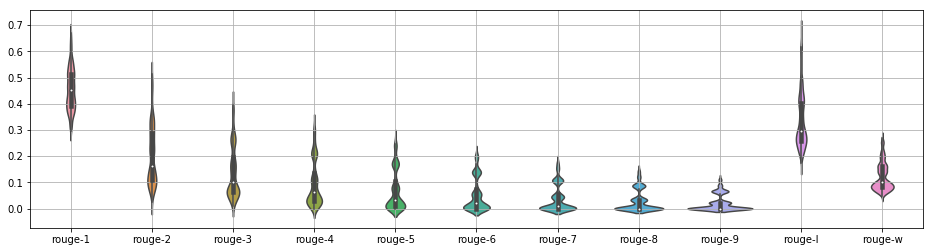

In [68]:
fig, ax = plt.subplots(figsize=(16, 4))
seaborn.violinplot(data=tester[tester.columns], ax=ax);
ax.grid()

In [69]:
stats = tester.describe()

In [70]:
rouge_max = stats.loc[['max']].transpose()
rouge_max

,max
rouge-1,0.670391
rouge-2,0.513966
rouge-3,0.406780
rouge-4,0.323699
rouge-5,0.269006
rouge-6,0.213018
rouge-7,0.179775
rouge-8,0.147727
rouge-9,0.114943
rouge-l,0.676805


In [71]:
benchmark_rouge = rouge_f_random_stats.iloc[:, rouge_f_random_stats.columns.get_level_values(1) == 'max'].copy()
benchmark_rouge.columns = benchmark_rouge.columns.get_level_values(1)
del benchmark_rouge.index.name
benchmark_rouge

,max
rouge-1,0.670391
rouge-2,0.513966
rouge-3,0.406780
rouge-4,0.323699
rouge-5,0.269006
rouge-6,0.213018
rouge-7,0.179775
rouge-8,0.147727
rouge-9,0.114943
rouge-l,0.676805


In [72]:
for ix, max_val in rouge_max.iterrows():
    print('{} ix={} score={}'.format(ix,
                                      rouge_f_summaries.query("metric == '{}' & f == {}".format(ix, max_val[0])).reset_index()['random_sum_ix'][0], 
                                      np.round(max_val[0], 2)))

rouge-1 ix=1103 score=0.67
rouge-2 ix=1674 score=0.51
rouge-3 ix=1674 score=0.41
rouge-4 ix=1103 score=0.32
rouge-5 ix=1103 score=0.27
rouge-6 ix=1103 score=0.21
rouge-7 ix=349 score=0.18
rouge-8 ix=349 score=0.15
rouge-9 ix=349 score=0.11
rouge-l ix=1103 score=0.68
rouge-w ix=1103 score=0.27


In [73]:
idx_sort = np.argsort(tester.sum(axis=1))[::-1]

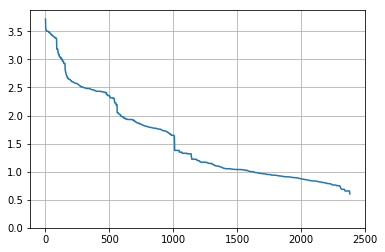

In [75]:
fig, ax = plt.subplots()
ax.plot(list(tester.loc[idx_sort].sum(axis=1)));
ax.set_ylim(bottom=0); ax.grid();

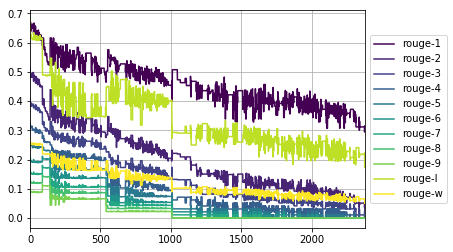

In [76]:
fig, ax = plt.subplots()
tester.loc[idx_sort, metrics].reset_index(drop=True).plot(colormap='viridis', ax=ax);
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)); ax.grid();

In [77]:
rouge_1_ix_sort = list(np.argsort(tester[['rouge-1']], axis=0)[::-1]['rouge-1'].values)
rouge_l_ix_sort = list(np.argsort(tester[['rouge-l']], axis=0)[::-1]['rouge-l'].values)
rouge_w_ix_sort = list(np.argsort(tester[['rouge-w']], axis=0)[::-1]['rouge-w'].values)

In [78]:
rouge_1_ix_sort[:10]

[1103, 1389, 1388, 1380, 1381, 1386, 1676, 1677, 1678, 1679]

In [79]:
rouge_l_ix_sort[:10]

[1103, 1674, 1716, 1704, 1719, 739, 1099, 1098, 1093, 1095]

In [80]:
rouge_w_ix_sort[:10]

[1103, 1674, 1716, 1704, 1719, 739, 1095, 1102, 1099, 1098]

In [81]:
random_summaries[1103]

' Animals such as dogs can buffer this stress response when humans fail to provide social support.  The Secretary of Veterans Affairs, acting through the Office of Patient Centered Care and Cultural Transformation, shall carry out a pilot program under which the Secretary shall provide to eligible veterans with service dogs.  The provision of a service dog under the pilot program shall be done in addition to other types of treatment provided for post-traumatic stress disorder and shall not replace established treatment modalities.  '

In [82]:
random_summaries[1674]

' The Secretary of Veterans Affairs, acting through the Office of Patient Centered Care and Cultural Transformation, shall carry out a pilot program under which the Secretary shall provide to eligible veterans with service dogs.  The provision of a service dog under the pilot program shall be done in addition to other types of treatment provided for post-traumatic stress disorder and shall not replace established treatment modalities.  The Secretary of Veterans Affairs shall furnish veterinary health insurance for each dog provided under the pilot program.  '

# Adding Complexity
Now that I have a very minimal model that runs, I need to add complexity to the model. 

In [83]:
import sumy

In [87]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

In [84]:
num_sentences_full = len(full_text.split('.'))
print('Full text is {} sentences'.format(num_sentences_full))

Full text is 17 sentences


In [85]:
target_summary_percentage = 0.25
num_sentences_sum = int(np.round(num_sentences_full*target_summary_percentage))
print('To achieve a summary that is approximately {}% we need provide a summary with {} sentences'.format(int(target_summary_percentage*100), num_sentences_sum))

To achieve a summary that is approximately 25% we need provide a summary with 4 sentences


### Latent Semantic Analysis.
Combines term freq with SVD (singular value decomposition)

#### Without stemming

In [88]:
summarizer = LsaSummarizer()

In [89]:
sumy_lsa_summarized = ""
full_text_parsed = PlaintextParser.from_string(full_text, Tokenizer('english'))
for sentence in summarizer(full_text_parsed.document, num_sentences_sum):
    #print(sentence)
    #print(' ')
    sumy_lsa_summarized += str(sentence) + " "

In [90]:
sumy_lsa_summarized

'Animals such as dogs can buffer this stress response when humans fail to provide social support. The provision of a service dog under the pilot program shall be done in addition to other types of treatment provided for post-traumatic stress disorder and shall not replace established treatment modalities. To be eligible for a service dog under the pilot program a veteran shall— be diagnosed with post-traumatic stress disorder rated at a severity level of three or four on the Clinician-Administered PTSD Scale for DSM–5 (CAPS–5); have been treated and have completed an established evidence-based treatment and remain significantly symptomatic, as evidenced by the Global Assessment of Functioning or a similar clinical metric; have served on active duty in the Armed Forces on or after September 11, 2001; and have not experienced satisfactory improvement in post-traumatic stress disorder symptoms after being treated with established evidence-based therapies. In carrying out the pilot program

In [91]:
sumy_lsa_summarized_rouge = apply_rouge_naive(sumy_lsa_summarized, actual_summary, 
                                              max_n=4, weight_factor=1.2, stemming=True)
sumy_lsa_summarized_rouge

,f,p,r
rouge-4,0.204082,0.194175,0.215054
rouge-1,0.544554,0.518868,0.572917
rouge-2,0.320000,0.304762,0.336842
rouge-3,0.252525,0.240385,0.265957
rouge-l,0.373773,0.358960,0.389860
rouge-w,0.169639,0.276208,0.122410


#### With stemming.

In [92]:
language = 'English'
stemmer_eng = Stemmer(language)

In [93]:
summarizer = LsaSummarizer(stemmer_eng)
summarizer.stop_words = get_stop_words(language)

In [94]:
sumy_lsa_summarized_stemmed = ""
full_text_parsed = PlaintextParser.from_string(full_text, Tokenizer('english'))
for sentence in summarizer(full_text_parsed.document, num_sentences_sum):
    #print(sentence)
    #print(' ')
    sumy_lsa_summarized_stemmed += str(sentence) + " "

In [95]:
sumy_lsa_summarized_stemmed_rouge = apply_rouge_naive(sumy_lsa_summarized_stemmed, actual_summary, 
                                              max_n=4, weight_factor=1.2, stemming=True)
sumy_lsa_summarized_stemmed_rouge

,f,p,r
rouge-4,0.020202,0.019048,0.021505
rouge-1,0.382353,0.361111,0.406250
rouge-2,0.118812,0.112150,0.126316
rouge-3,0.060000,0.056604,0.063830
rouge-l,0.278584,0.265562,0.292950
rouge-w,0.090009,0.144673,0.065326


In [96]:
actual_summary

'This bill directs the Department of Veterans Affairs (VA), through the Office of Patient Centered Care and Cultural Transformation, to carry out a five-year pilot program under which the VA shall provide service dogs and veterinary health insurance to certain veterans who: (1) served on active duty on or after September 11, 2001; and (2) were diagnosed with, and continue to suffer from, post-traumatic stress disorder. The provision of a service dog shall be done in addition to other types of treatment for post-traumatic stress disorder and shall not replace established treatment modalities.'

In [97]:
print("\n\n".join(sumy_lsa_summarized_stemmed.split('. ')))

The resulting hyperstimulation of the fight-flight-freeze response associated with post-traumatic stress disorder poses a threat to the successful societal reintegration of such members of the Armed Forces

Interaction with dogs has been shown to modulate symptoms of post-traumatic stress disorder, such as anxiety, including fear response and hyperarousal, interpersonal difficulties, social isolation, physical pain, and sleep disturbances

To be eligible for a service dog under the pilot program a veteran shall— be diagnosed with post-traumatic stress disorder rated at a severity level of three or four on the Clinician-Administered PTSD Scale for DSM–5 (CAPS–5); have been treated and have completed an established evidence-based treatment and remain significantly symptomatic, as evidenced by the Global Assessment of Functioning or a similar clinical metric; have served on active duty in the Armed Forces on or after September 11, 2001; and have not experienced satisfactory improvement in

In [98]:
print("\n\n".join(sumy_lsa_summarized.split('. ')))

Animals such as dogs can buffer this stress response when humans fail to provide social support

The provision of a service dog under the pilot program shall be done in addition to other types of treatment provided for post-traumatic stress disorder and shall not replace established treatment modalities

To be eligible for a service dog under the pilot program a veteran shall— be diagnosed with post-traumatic stress disorder rated at a severity level of three or four on the Clinician-Administered PTSD Scale for DSM–5 (CAPS–5); have been treated and have completed an established evidence-based treatment and remain significantly symptomatic, as evidenced by the Global Assessment of Functioning or a similar clinical metric; have served on active duty in the Armed Forces on or after September 11, 2001; and have not experienced satisfactory improvement in post-traumatic stress disorder symptoms after being treated with established evidence-based therapies

In carrying out the pilot program 

In [99]:
sumy_lsa_summarized

'Animals such as dogs can buffer this stress response when humans fail to provide social support. The provision of a service dog under the pilot program shall be done in addition to other types of treatment provided for post-traumatic stress disorder and shall not replace established treatment modalities. To be eligible for a service dog under the pilot program a veteran shall— be diagnosed with post-traumatic stress disorder rated at a severity level of three or four on the Clinician-Administered PTSD Scale for DSM–5 (CAPS–5); have been treated and have completed an established evidence-based treatment and remain significantly symptomatic, as evidenced by the Global Assessment of Functioning or a similar clinical metric; have served on active duty in the Armed Forces on or after September 11, 2001; and have not experienced satisfactory improvement in post-traumatic stress disorder symptoms after being treated with established evidence-based therapies. In carrying out the pilot program

### Lex Rank
Graphical based text summarizer
[SOURCE](https://medium.com/@ondenyi.eric/extractive-text-summarization-techniques-with-sumy-3d3b127a0a32)

In [869]:
from sumy.summarizers.lex_rank import LexRankSummarizer 

In [870]:
summarizer = LexRankSummarizer()

In [872]:
sumy_summarized_lexrank = ""
full_text_parsed = PlaintextParser.from_string(full_text, Tokenizer('english'))
for sentence in summarizer(full_text_parsed.document, num_sentences_sum):
    sumy_summarized_lexrank += str(sentence) + " "

In [875]:
sumy_summarized_lexrank

'The Secretary of Veterans Affairs, acting through the Office of Patient Centered Care and Cultural Transformation, shall carry out a pilot program under which the Secretary shall provide to eligible veterans with service dogs. The Secretary of Veterans Affairs shall furnish veterinary health insurance for each dog provided under the pilot program. To be eligible for a service dog under the pilot program a veteran shall— be diagnosed with post-traumatic stress disorder rated at a severity level of three or four on the Clinician-Administered PTSD Scale for DSM–5 (CAPS–5); have been treated and have completed an established evidence-based treatment and remain significantly symptomatic, as evidenced by the Global Assessment of Functioning or a similar clinical metric; have served on active duty in the Armed Forces on or after September 11, 2001; and have not experienced satisfactory improvement in post-traumatic stress disorder symptoms after being treated with established evidence-based 

In [874]:
apply_rouge_naive(sumy_summarized_lexrank, actual_summary)

,f,p,r
rouge-1,0.547264,0.523810,0.572917
rouge-2,0.291457,0.278846,0.305263
rouge-3,0.182741,0.174757,0.191489
rouge-4,0.102564,0.098039,0.107527
rouge-l,0.502496,0.484417,0.521977
rouge-w,0.171527,0.281125,0.123414


### Luhn
Scored based on freq of most important words. [SOURCE](https://medium.com/@ondenyi.eric/extractive-text-summarization-techniques-with-sumy-3d3b127a0a32)

In [876]:
from sumy.summarizers.luhn import LuhnSummarizer
summarizer = LuhnSummarizer()
sumy_summarized_luhn = ""
for sentence in summarizer(full_text_parsed.document, num_sentences_sum):
    sumy_summarized_luhn += str(sentence) + " "

In [879]:
print("\n\n".join(sumy_summarized_luhn.split('. ')))

To be eligible for a service dog under the pilot program a veteran shall— be diagnosed with post-traumatic stress disorder rated at a severity level of three or four on the Clinician-Administered PTSD Scale for DSM–5 (CAPS–5); have been treated and have completed an established evidence-based treatment and remain significantly symptomatic, as evidenced by the Global Assessment of Functioning or a similar clinical metric; have served on active duty in the Armed Forces on or after September 11, 2001; and have not experienced satisfactory improvement in post-traumatic stress disorder symptoms after being treated with established evidence-based therapies

To remain eligible to receive canine health insurance furnished by the Department of Veterans Affairs, a veteran shall see a physician who is a primary care provider or mental health care provider at a Department of Veterans Affairs medical facility at least quarterly

In carrying out the pilot program under this section, the Secretary sh

In [880]:
apply_rouge_naive(sumy_summarized_luhn, actual_summary)

,f,p,r
rouge-1,0.463054,0.439252,0.489583
rouge-2,0.208955,0.198113,0.221053
rouge-3,0.130653,0.123810,0.138298
rouge-4,0.071066,0.067308,0.075269
rouge-l,0.290273,0.277728,0.304005
rouge-w,0.101984,0.164976,0.073804


### Text Rank
Graph-based summarization technique with keyword extraction.

#### MUST also implement via pytextrank

In [881]:
from sumy.summarizers.text_rank import TextRankSummarizer
summarizer = TextRankSummarizer()
sumy_summarized_textrank = ""
for sentence in summarizer(full_text_parsed.document, num_sentences_sum):
    sumy_summarized_textrank += str(sentence) + " "

In [882]:
sumy_summarized_textrank

'To be eligible for a service dog under the pilot program a veteran shall— be diagnosed with post-traumatic stress disorder rated at a severity level of three or four on the Clinician-Administered PTSD Scale for DSM–5 (CAPS–5); have been treated and have completed an established evidence-based treatment and remain significantly symptomatic, as evidenced by the Global Assessment of Functioning or a similar clinical metric; have served on active duty in the Armed Forces on or after September 11, 2001; and have not experienced satisfactory improvement in post-traumatic stress disorder symptoms after being treated with established evidence-based therapies. In carrying out the pilot program under this section, the Secretary shall enter into such contracts as may be necessary for the procurement and training of service dogs with appropriate providers that are certified by Assistance Dogs International or a similar organization that— on average, provides one-on-one training for each service c

In [884]:
apply_rouge_naive(sumy_summarized_textrank, actual_summary)

,f,p,r
rouge-1,0.472906,0.448598,0.500000
rouge-2,0.218905,0.207547,0.231579
rouge-3,0.130653,0.123810,0.138298
rouge-4,0.071066,0.067308,0.075269
rouge-l,0.290273,0.277728,0.304005
rouge-w,0.101984,0.164976,0.073804


### TextRank with Pytextrank

In [ ]:
import pytextrank

In [895]:
#for ix, sentence in enumerate(full_text.split('.')):

In [898]:
text_dict = {"id":"1", "text":full_text}
text_json = json.dumps(text_dict)

In [ ]:
for graf in pytextrank.parse_doc(text_dict):
    print(graf._asdict())

### TextRank with Summa

In [915]:
import summa

### TextRank with NLTK.
[Source](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/)

In [917]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt') # one time execution
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/melissaferrari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### 1. Split into sentences.

In [100]:
sentences = nltk.tokenize.sent_tokenize(full_text)

#### 2. GloVe Word Embeddings (vector representation of words)

In [101]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2019-02-02 11:38:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu... 171.64.67.140
Connecting to nlp.stanford.edu|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-02-02 11:38:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip.1'

glove.6B.zip.1      100%[=====================>] 822.24M  3.59MB/s   in 3m 34s 

2019-02-02 11:42:00 (3.84 MB/s) - 'glove.6B.zip.1' saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [103]:
# Extract word vectors
f = open('glove.6B.100d.txt', encoding='utf-8')
word_embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [104]:
len(word_embeddings)

400000

#### 3. Text preprocessing.

In [105]:
# remove punctuations, numbers and special characters
clean_sentences = pd.Series(sentences).str.replace("[^a-zA-Z]", " ")

# make alphabets lowercase
clean_sentences = [s.lower() for s in clean_sentences]

In [106]:
clean_sentences[:2]

['this act may be cited as the  congress makes the following findings  an estimated    percent of members of the armed forces returning from active duty service in support of operation iraqi freedom or operation enduring freedom suffer from post traumatic stress disorder ',
 'the resulting hyperstimulation of the fight flight freeze response associated with post traumatic stress disorder poses a threat to the successful societal reintegration of such members of the armed forces ']

In [107]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/melissaferrari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [935]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [937]:
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [938]:
# remove stopwords from the sentences
clean_sentences = [remove_stopwords(r.split()) for r in clean_sentences]

#### 4. Vector representation of sentences.

In [942]:
sentence_vectors = []
for i in clean_sentences:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    sentence_vectors.append(v)

#### 5. Similarity Matrix.
Use cosine similarity to find similarities between sentences.

In [944]:
# similarity matrix
sim_mat = np.zeros([len(sentences), len(sentences)])

In [947]:
np.shape(sim_mat)

(16, 16)

In [945]:
from sklearn.metrics.pairwise import cosine_similarity

In [953]:
i = 4
j = 15

In [956]:
clean_sentences[i]

'secretary veterans affairs acting office patient centered care cultural transformation shall carry pilot program secretary shall provide eligible veterans service dogs'

In [957]:
clean_sentences[j]

'authority carry pilot program section shall terminate date five years date enactment act'

In [959]:
np.shape(sentence_vectors[i])

(100,)

In [961]:
np.shape(sentence_vectors[i].reshape(1,100))

(1, 100)

In [964]:
for i in range(len(sentences)):
    for j in range(len(sentences)):
        if i != j:
            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), 
                                              sentence_vectors[j].reshape(1,100))[0,0]

#### 6. Apply pagerank.

In [7]:
import networkx as nx

In [971]:
# Similarity matrix to graph
nx_graph = nx.from_numpy_array(sim_mat)

In [972]:
scores = nx.pagerank(nx_graph)

#### 7. Summary extraction.

In [977]:
ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

In [980]:
nltk_summarized_textrank = ""
for i in range(num_sentences_sum):
    nltk_summarized_textrank += str(ranked_sentences[i][1]) + " "

In [981]:
nltk_summarized_textrank

'The provision of a service dog under the pilot program shall be done in addition to other types of treatment provided for post-traumatic stress disorder and shall not replace established treatment modalities. The Secretary of Veterans Affairs, acting through the Office of Patient Centered Care and Cultural Transformation, shall carry out a pilot program under which the Secretary shall provide to eligible veterans with service dogs. This Act may be cited as the  Congress makes the following findings: An estimated 14 percent of members of the Armed Forces returning from active duty service in support of Operation Iraqi Freedom or Operation Enduring Freedom suffer from post-traumatic stress disorder. In carrying out the pilot program under this section, the Secretary shall enter into such contracts as may be necessary for the procurement and training of service dogs with appropriate providers that are certified by Assistance Dogs International or a similar organization that— on average, 

In [1014]:
rouge_nltk_textrank = apply_rouge_naive(nltk_summarized_textrank, actual_summary, max_n=9)[['f']]
rouge_nltk_textrank

,f
rouge-1,0.639594
rouge-2,0.461538
rouge-3,0.362694
rouge-4,0.293194
rouge-5,0.243386
rouge-6,0.192513
rouge-7,0.151351
rouge-8,0.120219
rouge-9,0.088398
rouge-l,0.391845


In [1021]:
np.divide(rouge_nltk_textrank['f'].values, benchmark_rouge['max'].values)

array([0.95406091, 0.89799331, 0.89162349, 0.90575916, 0.9047619 ,
       0.90374332, 0.84189189, 0.81378731, 0.76906077, 0.57896296,
       0.61219039])

### Supervised learning approach
[Supervised Machine Learning for Summarizaing Legal Documents](http://atour.iro.umontreal.ca/rali/sites/default/files/publis/SupervisedCanAI2010.pdf)

In [1031]:
ordered_tags = []
for elt in tree.getiterator():
    tag = elt.tag
    if '}' in tag:
        tag = tag.split('}')[1]
    ordered_tags.append(tag)
unique_tags = list(np.unique(tags))

In [1033]:
for elt in tree.getiterator():
    print('{} --> {}'.format(elt.tag, elt.text))

bill --> 
	
metadata --> 

dublinCore --> 

{http://purl.org/dc/elements/1.1/}title --> 114 HR 4764 IH: Puppies Assisting Wounded Servicemembers (PAWS) Act of 2016
{http://purl.org/dc/elements/1.1/}publisher --> U.S. House of Representatives
{http://purl.org/dc/elements/1.1/}date --> 2016-03-16
{http://purl.org/dc/elements/1.1/}format --> text/xml
{http://purl.org/dc/elements/1.1/}language --> EN
{http://purl.org/dc/elements/1.1/}rights --> Pursuant to Title 17 Section 105 of the United States Code, this file is not subject to copyright protection and is in the public domain.
form --> 
		
distribution-code --> I
congress --> 114th CONGRESS
session --> 2d Session
legis-num --> H. R. 4764
current-chamber --> IN THE HOUSE OF REPRESENTATIVES
action --> 
			
action-date --> March 16, 2016
action-desc --> None
sponsor --> Mr. DeSantis
cosponsor --> Mr. Rooney of Florida
cosponsor --> Mr. Rothfus
cosponsor --> Ms. Stefanik
cosponsor --> Mr. Nugent
cosponsor --> Mr. Weber of Texas
cosponsor --

In [1037]:
ordered_tags[:10]

['bill',
 'metadata',
 'dublinCore',
 'title',
 'publisher',
 'date',
 'format',
 'language',
 'rights',
 'form']

#### Unsupervised Text Summarization
[SOURCE](https://medium.com/jatana/unsupervised-text-summarization-using-sentence-embeddings-adb15ce83db1)

In [1035]:
from sklearn import cluster

In [1036]:
kmeans = cluster.KMeans(n_clusters=num_sentences_sum)

In [1039]:
kmeans_output = kmeans.fit(sentence_vectors)

In [1041]:
from sklearn import metrics

In [1044]:
avg = []
for j in range(num_sentences_sum):
    idx = np.where(kmeans.labels_ == j)[0]
    avg.append(np.mean(idx))

In [1050]:
cluster_centers = kmeans.cluster_centers_

In [1056]:
closest, distances = metrics.pairwise_distances_argmin_min(cluster_centers, 
                                                           sentence_vectors)

In [1059]:
ordering = sorted(range(num_sentences_sum), key=lambda k: avg[k])

In [1066]:
summary = ' '.join([sentences[closest[idx]] for idx in ordering])

In [1067]:
summary

'To be eligible for a service dog under the pilot program a veteran shall— be diagnosed with post-traumatic stress disorder rated at a severity level of three or four on the Clinician-Administered PTSD Scale for DSM–5 (CAPS–5); have been treated and have completed an established evidence-based treatment and remain significantly symptomatic, as evidenced by the Global Assessment of Functioning or a similar clinical metric; have served on active duty in the Armed Forces on or after September 11, 2001; and have not experienced satisfactory improvement in post-traumatic stress disorder symptoms after being treated with established evidence-based therapies. The Secretary of Veterans Affairs, acting through the Office of Patient Centered Care and Cultural Transformation, shall carry out a pilot program under which the Secretary shall provide to eligible veterans with service dogs. The Secretary may not obligate or expend more than $27,000 for the procurement and training of any dog under a c

In [1068]:
apply_rouge_naive(summary, actual_summary)

,f,p,r
rouge-1,0.463054,0.439252,0.489583
rouge-2,0.208955,0.198113,0.221053
rouge-3,0.130653,0.123810,0.138298
rouge-4,0.071066,0.067308,0.075269
rouge-l,0.290273,0.277728,0.304005
rouge-w,0.103664,0.167693,0.075020


### Ideas

In [1069]:
query_text = "SELECT bill_ix, text FROM bill_text;"
query_text_results = pd.read_sql_query(query_text, con)

In [1072]:
def create_single_text_string(tree, tag='text'):
    text = ""
    for elt in tree.getiterator(tag):
        if isinstance(elt.text, str):
            text += elt.text  + ' '
    return text

In [ ]:

def do_summarization(string_xml):
    string_length = len(string_xml)
    print('text length: {}'.format(string_length))
    tree = etree.fromstring(string_xml)

    text = create_single_text_string(tree, tag='text')

    summarized = summarization.summarize(text)
    print('summary length: {}'.format(len(summarized)))

    return summarized

In [ ]:
string_xml = query_text_results.iloc[0]['text']
tree = etree.fromstring(string_tree)
#summarization_result = models.do_summarization(string_xml)
full_text = create_single_text_string(tree)

In [ ]:
tree = etree.parse(os.path.join(bill_path, xml_file))
string_tree = etree.tostring(tree).decode()

In [1075]:
query_text_results['tree'] = query_text_results['text'].apply(etree.fromstring)


In [1080]:
query_text_results['full_text'] = query_text_results['tree'].apply(create_single_text_string)

In [1081]:
query_text_results.head()

,bill_ix,text,tree,full_text
0,5529,"<?xml-stylesheet type=""text/xsl"" href=""billres...",[[[<Element {http://purl.org/dc/elements/1.1/}...,This Act may be cited as the Not later than 9...
1,5530,"<?xml-stylesheet type=""text/xsl"" href=""billres...",[[[<Element {http://purl.org/dc/elements/1.1/}...,This Act may be cited as the Congress makes t...
2,5531,"<?xml-stylesheet type=""text/xsl"" href=""billres...",[[[<Element {http://purl.org/dc/elements/1.1/}...,This Act may be cited as the Subchapter I of ...
3,5588,"<?xml-stylesheet type=""text/xsl"" href=""billres...",[[[<Element {http://purl.org/dc/elements/1.1/}...,This Act may be cited as the For each fiscal ...
4,5589,"<?xml-stylesheet type=""text/xsl"" href=""billres...",[[[<Element {http://purl.org/dc/elements/1.1/}...,This Act may be cited as the an organization ...


In [1087]:
query_text_results['tokenize'] = query_text_results['full_text'].apply(sent_tokenize)

In [1094]:
query_text_results['num_sentences'] = query_text_results['tokenize'].apply(len).astype(int)

In [1097]:
query_text_results['num_sentences'].describe()

count    5550.000000
mean       19.904685
std        60.348962
min         1.000000
25%         2.000000
50%         7.000000
75%        18.000000
max      1871.000000
Name: num_sentences, dtype: float64

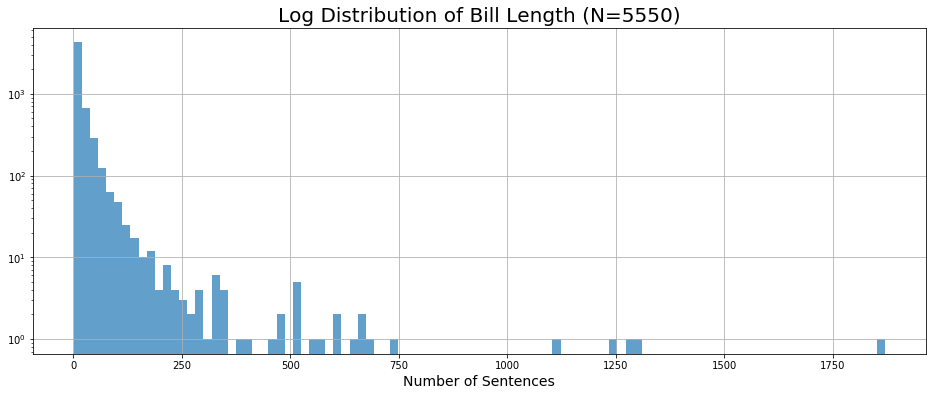

In [1121]:
fig, ax = plt.subplots(figsize=(16, 6))
query_text_results['num_sentences'].hist(bins=100, ax=ax, alpha=0.7);
ax.set_yscale('log'); #ax.set_xlim(xmin=0);
ax.set_xlabel('Number of Sentences', size=14);
ax.set_title('Log Distribution of Bill Length (N=5550)', size=20);

In [ ]:
query_text_results[query_text_results['num_sentences'] > query_text_results['num_sentences'].describe()['50%']]

In [1201]:
long_bill = query_text_results.loc[query_text_results['num_sentences'] == 
                                         query_text_results['num_sentences'].describe()['max']]

In [1195]:
longest_bill_ix = query_text_results.loc[query_text_results['num_sentences'] == 
                                         query_text_results['num_sentences'].describe()['max'], 'bill_ix'].values[0]

In [1196]:
longest_bill = query_text_results.loc[query_text_results['num_sentences'] == 
                                      query_text_results['num_sentences'].describe()['max'], 'tokenize'].values[0]

In [1169]:
query_text_results.loc[query_text_results['num_sentences'] == 
                                      query_text_results['num_sentences'].describe()['max']]

,bill_ix,text,tree,full_text,tokenize,num_sentences
25,9589,"<?xml-stylesheet type=""text/xsl"" href=""billres...",[[[<Element {http://purl.org/dc/elements/1.1/}...,This Act may be cited as the The table of con...,[This Act may be cited as the The table of co...,1871


In [1244]:
official_title

'To improve the health of minority individuals, and for other purposes.'

In [1180]:
longest_bill_ix

9589

In [1188]:
query_info = "SELECT bill_id, official_title, short_title, subjects_top_term FROM bills WHERE id='%s';" % longest_bill_ix
query_info_results = pd.read_sql_query(query_info, con)

In [1190]:
bill_id, official_title, short_title, subjects_top_term = query_info_results.loc[0].values

In [1191]:
bill_id

'hr5475-114'

In [1192]:
query_summary = """
                SELECT bill_ix, text FROM summaries bt INNER JOIN bills b
                ON bt.bill_ix = b.id WHERE b.bill_id = '%s';
                """

In [1193]:
data = (bill_id,)
query_summary_results = pd.read_sql_query(query_summary % data, con)
query_summary_results

,bill_ix,text
0,9589,Health Equity and Accountability Act of 2016\n...


In [1206]:
tree = etree.fromstring(long_bill.loc[25, 'text'])

In [1208]:
ordered_tags = []
for elt in tree.getiterator():
    tag = elt.tag
    if '}' in tag:
        tag = tag.split('}')[1]
    ordered_tags.append(tag)
unique_tags = list(np.unique(tags))

In [1243]:
unique_tags[:10]

['act-name',
 'action',
 'action-date',
 'action-desc',
 'after-quoted-block',
 'bill',
 'chapter',
 'clause',
 'committee-name',
 'congress']

In [1242]:
ordered_tags[:10]

['bill',
 'metadata',
 'dublinCore',
 'title',
 'publisher',
 'date',
 'format',
 'language',
 'rights',
 'form']

In [1249]:
from nltk# import tokenize #import sent_tokenize

In [109]:
full_sent = nltk.tokenize.sent_tokenize(full_text)
summ_sent = nltk.tokenize.sent_tokenize(actual_summary)

In [136]:
sim_mat = np.zeros([len(full_sent), len(summ_sent)])

In [111]:
from sklearn.metrics.pairwise import cosine_similarity

In [113]:
full_sent_clean = pd.Series(full_sent).str.replace("[^a-zA-Z]", " ")

In [114]:
summ_sent_clean = pd.Series(summ_sent).str.replace("[^a-zA-Z]", " ")

In [117]:
# make alphabets lowercase
summ_sent_clean = [s.lower() for s in summ_sent_clean]
full_sent_clean = [s.lower() for s in full_sent_clean]

In [ ]:
from nltk.corpus import stopwords

In [118]:
stop_words = nltk.corpus.stopwords.words('english')
# function to remove stopwords
def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new

In [119]:
# remove stopwords from the sentences
summ_sent_clean = [remove_stopwords(r.split()) for r in summ_sent_clean]
full_sent_clean = [remove_stopwords(r.split()) for r in full_sent_clean]

In [144]:
summ_sentence_vectors = []
for i in summ_sent_clean:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    summ_sentence_vectors.append(v)
full_sentence_vectors = []
for i in full_sent_clean:
    if len(i) != 0:
        v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
    else:
        v = np.zeros((100,))
    full_sentence_vectors.append(v)

In [145]:
np.shape(sim_mat)

(16, 2)

In [138]:
sim_mat[5][1]

0.0

In [143]:
np.shape(full_sentence_vectors)

(2, 100)

In [149]:
for i in range(len(full_sent)):
    for j in range(len(summ_sent)):
            sim_mat[i][j] = cosine_similarity(full_sentence_vectors[i].reshape(1,100), 
                                              summ_sentence_vectors[j].reshape(1,100))[0,0]

In [150]:
sim_mat

array([[0.91735315, 0.87459004],
       [0.84506869, 0.84888577],
       [0.8259142 , 0.86032683],
       [0.7629053 , 0.81978511],
       [0.95249951, 0.87305421],
       [0.93604189, 0.98994952],
       [0.91544795, 0.81710064],
       [0.92808485, 0.93059683],
       [0.95272976, 0.84556741],
       [0.9176293 , 0.86911321],
       [0.79945445, 0.76730931],
       [0.87854075, 0.80809921],
       [0.89066541, 0.92094696],
       [0.84576815, 0.78002995],
       [0.88902825, 0.80967653],
       [0.84630245, 0.84506655]])

In [152]:
type(sim_mat)

numpy.ndarray

In [164]:
ix_match = np.argmax(sim_mat, axis=0)
ix_match

array([8, 5])

In [166]:
sim_mat[:, 0]

array([0.91735315, 0.84506869, 0.8259142 , 0.7629053 , 0.95249951,
       0.93604189, 0.91544795, 0.92808485, 0.95272976, 0.9176293 ,
       0.79945445, 0.87854075, 0.89066541, 0.84576815, 0.88902825,
       0.84630245])

In [165]:
sim_mat[8, 0]

0.9527297616004944

In [167]:
sim_mat[:, 1]

array([0.87459004, 0.84888577, 0.86032683, 0.81978511, 0.87305421,
       0.98994952, 0.81710064, 0.93059683, 0.84556741, 0.86911321,
       0.76730931, 0.80809921, 0.92094696, 0.78002995, 0.80967653,
       0.84506655])

In [169]:
sim_mat[5, 1]

0.9899495244026184

In [170]:
closest_match = [full_sent[i] for i in ix_match]
closest_match

['To remain eligible to receive canine health insurance furnished by the Department of Veterans Affairs, a veteran shall see a physician who is a primary care provider or mental health care provider at a Department of Veterans Affairs medical facility at least quarterly.',
 'The provision of a service dog under the pilot program shall be done in addition to other types of treatment provided for post-traumatic stress disorder and shall not replace established treatment modalities.']